In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import pydicom
import time
import gc
import operator 
from apex import amp 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
from apex import amp
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 8153
device=device_by_name("Tesla")
#device=device_by_name("RTX")
#device = "cpu"
sendmeemail=Email_Progress(my_gmail,my_pass,to_email,'Densenet169-folds-FullHead results')

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.shape
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df=train_df.drop_duplicates().reset_index(drop=True)
train_df.shape
train_df.head()

(674510, 15)

(674252, 15)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [ ]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [ ]:
split_sid = train_df.PID.unique()
splits=list(KFold(n_splits=3,shuffle=True, random_state=SEED).split(split_sid))


In [ ]:
def my_loss(y_pred,y_true,weights):
    loss = F.binary_cross_entropy_with_logits(y_pred,y_true,weights.repeat(y_pred.shape[0],1))
    loss=loss*y_pred.shape[0]/34.5 #use just for full heads, slices per head 
    return loss

In [ ]:
class parameter_scheduler():
    def __init__(self,model,do_first=['classifier'],num_epoch=1):
        self.model=model
        self.do_first = do_first
        self.num_epoch=num_epoch
    def __call__(self,epoch):
        if epoch>=self.num_epoch:
            for n,p in self.model.named_parameters():
                p.requires_grad=True
        else:
            for n,p in self.model.named_parameters():
                p.requires_grad= any(nd in n for nd in self.do_first)


In [ ]:
def get_optimizer_parameters(model,klr):
    zero_layer=['conv0','norm0','ws_norm']
    param_optimizer = list(model.named_parameters())
    num_blocks=4
    no_decay=['bias']
    optimizer_grouped_parameters=[
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and any(nd in n for nd in zero_layer))], 'lr':klr*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and any(nd in n for nd in zero_layer)], 'lr':klr*2e-5, 'weight_decay': 0.0}
        ]
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('wso' in n))], 'lr':klr*1e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('wso' in n)], 'lr':klr*1e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
        ])
    for i in range(num_blocks):
        optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('denseblock{}'.format(i+1) in n))], 'lr':klr*(2.0**i)*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('denseblock{}'.format(i+1) in n)], 'lr':klr*(2.0**i)*2e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('norm5' in n))], 'lr':klr*1e-4,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('norm5' in n)], 'lr':klr*1e-4, 'weight_decay': 0.0}
        ])
    return(optimizer_grouped_parameters)

    

(11386,)

(5693,)

<IPython.core.display.Javascript object>


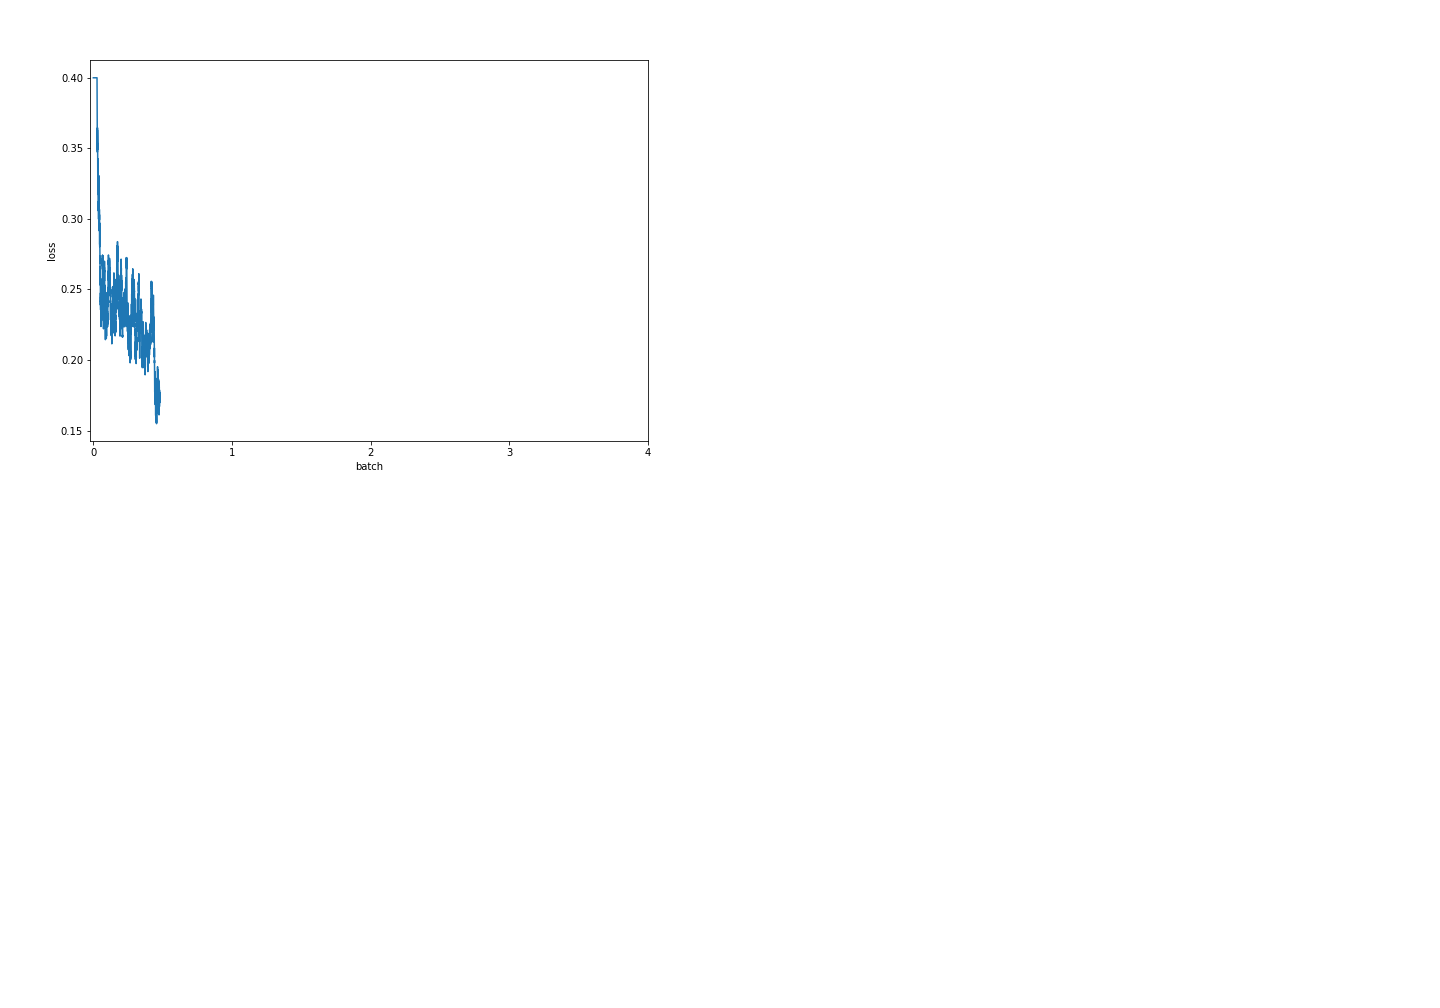

In [ ]:
%matplotlib nbagg

num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
#torch.backends.cudnn.deterministic = True
idx_train = splits[num_split][0]
idx_validate =  splits[num_split][1]
idx_train.shape
idx_validate.shape

klr=1
batch_size=1
num_workers=12
num_epochs=4
model_name,version = 'Densenet169_3' , 'fullheadimage'
model = MyDenseNet(models.densenet169(pretrained=True),
                   len(hemorrhage_types),
                   num_channels=3,
                   drop_out=0.2,
                   wso=((40,80),(80,200),(600,2800)),
                   strategy='none',
                   dont_do_grad=[],
                   pool_type='max',
                   extra_pool=8,
                   )

_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset= FullHeadImageDataset( train_df,
                                     train_images_dir,
                                     train_df.SeriesI.unique(),
                                     'SeriesI',
                                     'ImagePositionZ',
                                     transform=transform.random,
                                     window_eq=False,
                                     equalize=False,
                                     rescale=True, 
                                     target_columns=hemorrhage_types)
transform_val=MyTransform(out_size=512)
imagedataset_val = FullHeadImageDataset( train_df,
                                     train_images_dir,
                                     train_df.SeriesI.unique(),
                                     'SeriesI',
                                     'ImagePositionZ',
                                     transform=transform_val.random,
                                     window_eq=False,
                                     equalize=False,
                                     rescale=True, 
                                     target_columns=hemorrhage_types)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sample_ratio=1.
train_dataset=D.Subset(imagedataset,idx_train)
validate_dataset=D.Subset(imagedataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1,limits=[0.05,0.4])
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=1.5)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
sampler=simple_sampler(idx_train,1.0)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                use_batchs = False,
                                do_apex=False,
                                model_apexed=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampler,
                                graph=gr,
                                call_progress=sendmeemail)
torch.save(model.state_dict(), models_dir+models_format.format(model_name,version,num_split))
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version+'_best',num_split))

In [ ]:
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier_wso2',2
model = MyDenseNet(models.densenet161(pretrained=True),
                   len(hemorrhage_types),
                   num_channels=3,
                   drop_out=0.2,
                   wso=((40,80),(80,200),(600,2800)),
                   strategy='none',
                   dont_do_grad=[],
                   extra_pool=4,
                   pool_type='max',
                   return_features=True
                   )
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
transform_val=MyTransform(out_size=512)
indexes=np.arange(train_df.shape[0]).repeat(4)
train_dataset=D.Subset(ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                          window_eq=False,equalize=False,rescale=True),indexes)
pred,features = model_run(model,train_dataset,do_apex=True,batch_size=96,num_workers=14)

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_train_tta',num_split),'wb')
pickle.dump(pred,pickle_file,protocol=4)
pickle_file.close()


my_loss(pred[(idx_validate*4+np.arange(4)[:,None]).transpose(1,0)].mean(1),
        torch.tensor(train_df[hemorrhage_types].values[idx_validate],dtype=torch.float),
        torch.tensor([1.,1.,1.,1.,1.,2.]))

In [13]:
model_name,version, num_split = 'Densenet161_3' , 'classifier__splits',0
model = MyDenseNet(models.densenet161(pretrained=True),
                   len(hemorrhage_types),
                   num_channels=3,
                   drop_out=0.2,
                   wso=((40,80),(80,200),(600,2800)),
                   strategy='none',
                   dont_do_grad=[],
                   extra_pool=4,
                   pool_type='max',
                   return_features=True
                   )
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
transform_val=MyTransform(out_size=512)
indexes=np.arange(test_df.shape[0]).repeat(8)
imagedataset_test=D.Subset(ImageDataset(test_df,transform=transform.random,base_path=test_images_dir,
                              window_eq=False,equalize=False,rescale=True),indexes)
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=18)
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_test',num_split),'wb')
pickle.dump(pred,pickle_file,protocol=4)
pickle_file.close()

<All keys matched successfully>

In [14]:
submission_df=get_submission(test_df,pred[(np.arange(pred.shape[0]).reshape(pred.shape[0]//8,8))].mean(1))
#submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=25
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,0.002726
1,ID_000012eaf_epidural,0.000023
2,ID_000012eaf_intraparenchymal,0.000494
3,ID_000012eaf_intraventricular,0.000140
4,ID_000012eaf_subarachnoid,0.000619
5,ID_000012eaf_subdural,0.001694
6,ID_0000ca2f6_any,0.004521
7,ID_0000ca2f6_epidural,0.000045
8,ID_0000ca2f6_intraparenchymal,0.000900
9,ID_0000ca2f6_intraventricular,0.000160


(471270, 2)